# Find an optimal policy with Finite Markov Decision Process

In this series of Jupyter notebooks, we will delve into various methods for finding an optimal policy within the context of Finite Markov Decision Processes (MDPs). 

## Series Overview
The series is structured into three parts, each focusing on a different approach for solving MDPs:

**Part 1: Dynamic Programming**

**Part 2: Monte Carlo Methods**

**Part 3: TD Learning**

# Part 2: Monte Carlo Methods


## (Review) What is a Markov Decision Process (MDP)?

In the field of Reinforcement Learning (RL), Markov Decision Processes (MDPs) are fundamental mathematical models used for decision-making in dynamic environments. An MDP consists of several key components:

- **States (S)**: Possible situations or configurations within the environment.

- **Actions (A)**: A set of choices or decisions that an agent can make.

- **Transitions (T)**: Rules or probabilities governing how the environment moves from one state to another after taking a specific action.

- **Rewards (R)**: Immediate numerical values that indicate the desirability of an agent's actions.

- **Discount Factor (γ)**: A factor that balances immediate rewards against future rewards.

The key characteristic of an MDP is that the future state and reward depend only on the current state. 


In the previous notebook, I introduced a method for determining the optimal policy using Dynamic Programming. This approach involves iteratively updating the value function and policy with the Bellman equation. However, this update operation relies on having knowledge of the environment's dynamics.

In reality, we often lack complete knowledge of these dynamics. In this notebook, we will explore a method for solving Finite Markov Decision Processes (MDP) without requiring knowledge of the environment. Instead, we will focus on learning a value function and policy through experience by collecting sequences of states, actions, and rewards obtained from interactions with the environment. Specifically, we will learn Monte Carlo Methods, which solve finite MDPs by averaging sample returns.

___

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP
import seaborn as sns
from IPython.display import clear_output


# Prepare Frozen Lake environment

As in the last notebook, we will use the frozen lake environment in gymnasium.

[Learn more about the Frozen Lake environment](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

The objective of this environment is for an agent to navigate through a grid world, starting from the initial cell and reaching the goal cell. Here, we are using a 4x4 grid map, and each cell falls into one of four different categories:

- **S (Start)**: This cell is where our agent begins its journey.

- **F (Frozen)**: These cells are safe for the agent to walk on.

- **H (Hole)**: These are hazardous cells, and if the agent falls into one, the episode terminates with a reward of 0.

- **G (Goal)**: Reaching this cell yields a reward of +1 for the agent.

From the starting cell, the agent has the option to move in four directions: up, left, down, or right. The agent's task is to explore the grid world, making decisions at each time step to eventually reach the goal cell and collect a reward of +1.

In the below code, we can see an example of the agent randomly exploring this environment over 100 time steps.


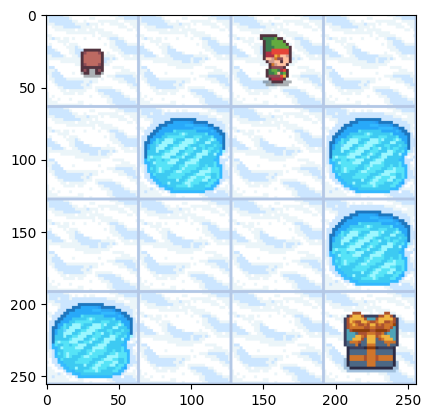

In [2]:
# Create the FrozenLake environment with specific settings
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode="rgb_array")

# Reset the environment to its initial state and get the initial observation (initial state)
observation, info = env.reset(seed=2023)
num_state = env.observation_space.n
num_action = env.action_space.n

# Simulate the agent's actions for 100 time steps
for _ in range(100):
    # Choose a random action from the action space
    action = env.action_space.sample()

    # Take the chosen action and observe the resulting state, reward, and termination status
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode is terminated, reset the environment to the start cell
    if terminated:
        observation, info = env.reset()

    # Display the current state of the environment
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

env.close()


## Estimating State Values with Monte Carlo Methods

In this section, we'll explore how Monte Carlo (MC) methods can be used to estimate the state values in a MDP when we don't have prior knowledge of the environment's dynamics.

Let's assume that our policy is a random action policy, meaning it doesn't follow any specific strategy. Here, we assume that we lack knowledge about the dynamics of the environment. However, we can collect experience by repeatedly executing actions according to this random policy. Through these experiences, we can identify which states are associated with receiving rewards.

### Definition of Return

In this context, we define the "return" as the total discounted reward, starting from the current timestep. Mathematically, return is represented as:

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots = \sum_{k=t+1}^{T} \gamma^{k-t-1} R_k$$

Here, $G_t$ represents the return at time $t$, $R_t$ is the reward at time $t$, and $\gamma$ is the discount factor. It accounts for the fact that future rewards are worth less than immediate rewards.

### Monte Carlo Methods for Value Estimation

MC Methods utilize the concept of return to compute the value of each state. States that lead to higher total discounted rewards in the long run will be assigned greater state values.

More precisely, MC methods calculate the state value by taking the average of the observed returns obtained after visiting each state. As more returns are sampled, this average tends to converge to the expected value of the return that can be obtained from the state.

Below is the pseudocode for estimating the state value under a specific policy $\pi$ using MC methods:



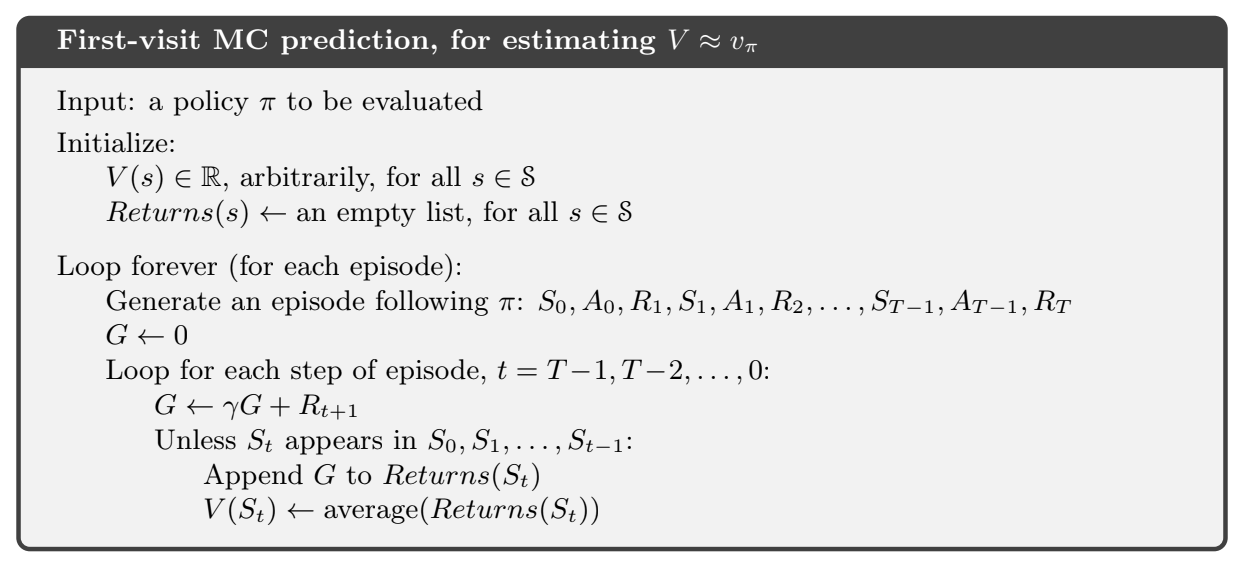

The general idea can be summarized in the following steps:

1. **Generate a Policy $\pi$:** Choose or generate a policy $\pi$ (e.g., random exploration, $\epsilon$-greedy policy).

2. **Initialization:** Initialize state values and return variables for each state.

3. **Episode Generation:** In each iteration, generate an episode.

4. **Backward Return Calculation:** Iterate through time steps from the endpoint of the episode backward and compute the return $G$ after each time step $t$. This backward calculation simplifies the computation of the return.

5. **Update State Values:** If time step $t$ marks the first visit to a state $s$, append the current return to a list of returns for state $s$, and update the state value $V(S_t)$. Here, $S_t$ is the state visited at time step $t$. The update is done by computing the average return of state $s$ over episodes.

6. **Repeat:** After iterating through all time steps in an episode, return to step 3 and continue the process.

In summary, the MC method computes state values by averaging the expected returns after visiting state $s$ over many episodes.

While the method outlined above relies on the first visit to a state for updating state values (first-visit MC), there's an alternative approach known as every-visit MC. In the every-visit MC method, state values are updated based on every visit to the state, rather than just the first visit. The first-visit MC method estimates $V_{\pi}(s)$ as the average of the returns following the first visits to state $s$, whereas the every-visit MC method averages the returns following all visits to state $s$. In this notebook, we will primarily focus on the first-visit method, which has been the most widely studied.

With many episodes, the state value $V_{\pi}(s)$ converges to the true values, following the Law of Large Numbers. Let's see the implementation of this method. For our policy $\pi$ to evaluate, we will use an optimal $\epsilon$-greedy policy, where we exploit the optimal action (manually chosen) with probability $1-\epsilon$ and explore random actions with probability $\epsilon$.


In [3]:
def generate_episode(env, policy, epsilon=0.1, render=False):
    """
    Generates an episode by executing the current policy in the given environment.
    """
    states = []
    actions = []
    rewards = []
    state, info = env.reset()
    terminated = False

    while not terminated:
        # take a step
        action = np.random.choice(env.action_space.n, p=np.squeeze(policy[state])) # choose an action according to the probability
        observation, reward, terminated, _, info = env.step(action)

        # store state and action
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        # update state
        state = observation

        # render the env
        if render:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()

    return states, actions, rewards


def mc_policy_evaluation(env, policy, value_func, gamma=0.9, num_episode=1000, plot_heatmap=False):
    """
    Run MC policy evaluation.
    """
    # Initialization
    visited_cnt = np.zeros(num_state)
    return_sum = np.zeros(num_state)

    for i in range(num_episode):
        G = 0
        
        # Generate an episode
        states, actions, rewards = generate_episode(env, policy)
        T = len(states)

        # Iterate over all time steps
        for t in reversed(range(T)):
            G = gamma * G + rewards[t] # rewards[t] corresponds to R_{t+1}
            state = states[t]

            # Update the value function when the state is first visit
            if state not in states[0:t]: # states[0:t] returns a list of states visited between 0 and t-1 time steps
                return_sum[state] += G
                visited_cnt[state] += 1
                value_func[state] = return_sum[state] / visited_cnt[state] # compute the average return after the first visit

        # Visualize the heatmap of the value_func during learning
        if plot_heatmap and i % 50 == 0:
            plot_value_func_heatmap(env, value_func, eps_ind=i)

    # Visualize the heatmap of the final output value_func
    if plot_heatmap:
        plot_value_func_heatmap(env, value_func)

    return value_func


def plot_value_func_heatmap(env, value_func, eps_ind=None):
    """
    Plots the heatmap of the state value function.
    """
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(np.reshape(value_func, [env.nrow, env.ncol]),
                annot=True, linewidths=.5, cmap="GnBu_r", ax=ax,
                yticklabels=np.arange(1, env.nrow + 1)[::-1],
                xticklabels=np.arange(1, env.nrow + 1),
                vmin=0, vmax=1)
    if eps_ind is None:
        plt.title('State value heatmap', fontsize=15)
    else:
        plt.title(f"State value heatmap, Episode: {eps_ind}", fontsize=15)
                           
    return None


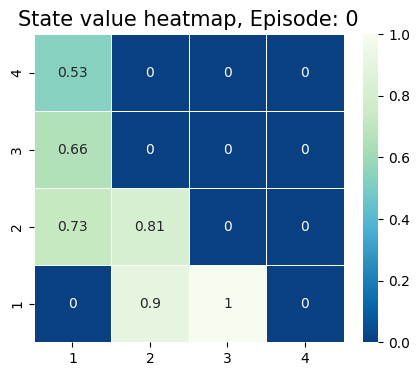

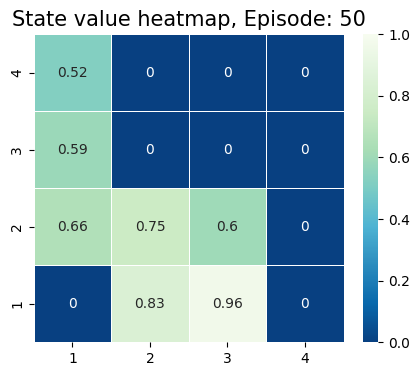

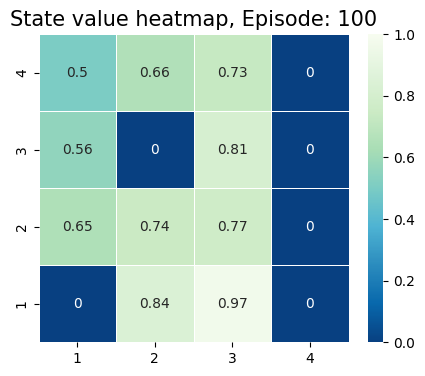

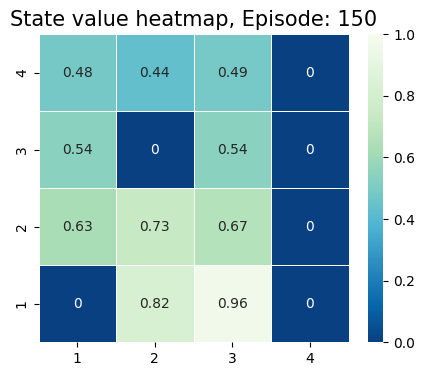

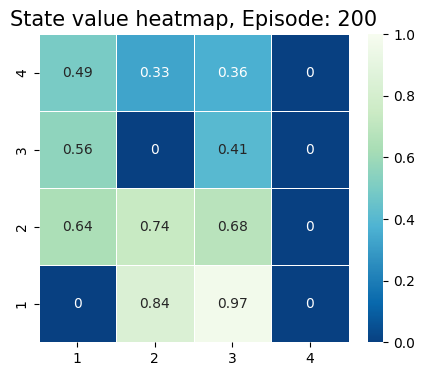

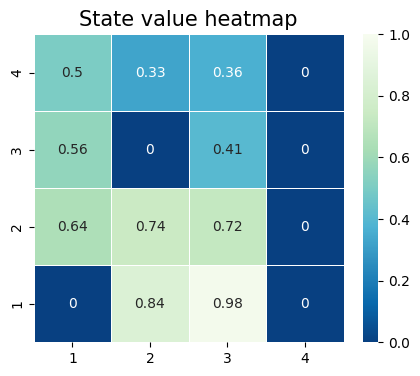

In [4]:
# MC implementation
value_func = np.zeros(num_state)

# Initialize an optimal epsilon-greedy policy
epsilon = 0.1
policy = np.zeros([num_state, num_action])
opt_action = [1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0]
for state in range(num_state):
    for action in range(num_action):
        if action == opt_action[state]:
            policy[state][action] = 1 - epsilon + 1/num_action * epsilon
        else:
            policy[state][action] = 1/num_action * epsilon

# Run policy evaluation with MC method
value_func = mc_policy_evaluation(env, policy, value_func, num_episode=250, plot_heatmap=True)


From the learned state values, we observe that cells closer to the goal exhibit higher values compared to those farther from the goal, which makes sense because we have the discount factor. So we can estimate the state values using MC methods.


## Estimating Action Values with Monte Carlo Methods

Now, the key question is how we can learn the optimal policy without knowledge of the dynamics. While state values indicate which states have higher values, they don't provide information about the actions required to reach these high-value states. To illustrate this, consider a chessboard where we know the value of each state, suggesting good states we aim to reach. However, in the absence of knowledge about the dynamics, we lack guidance on which actions to take to attain those desirable board states.

In scenarios where we do know the dynamics, we can simulate the environment by taking actions and observing the outcomes (i.e. look ahread), enabling us to learn which actions lead to favorable results. In other words, with access to the dynamics, state values alone suffice to determine a policy by looking one step ahead and selecting the action that yields the highest value. 

However, in the absence of a model, state values alone are insufficient. It becomes essential to explicitly estimate the value of each action to make these values meaningful in guiding policy decisions. Thus, when we lack a model of the dynamics, estimating action values, instead of state values, becomes a valuable approach.

Action value, denoted as $Q(s, a)$, quantifies the value of taking a specific action $a$ in state $s$. 

In the following code, we'll rearrange the previous implementation to estimate action values using the Monte Carlo method. This process involves some minor modifications. Our objective is to estimate $q_{\pi}(s, a)$, representing the expected return when starting in state $s$, taking action $a$, and subsequently following policy $\pi$.


In [5]:
def mc_policy_evaluation_action_value(env, policy, value_func, gamma=0.9, num_episode=1000):
    """
    Run MC policy evaluation for action values.
    """
    # Initialization
    visited_cnt = np.zeros([num_state, num_action])
    return_sum = np.zeros([num_state, num_action])

    for i in range(num_episode):
        G = 0

        # Generate an episode
        states, actions, rewards = generate_episode(env, policy)
        state_action_pairs = np.array([states, actions]).T  # Dimension: [num_timestep, 2]
        T = len(states)

        # Iterate over all time steps
        for t in reversed(range(T)):
            G = gamma * G + rewards[t]
            state = states[t]
            action = actions[t]
            state_action_pair = [state, action]

            # Update the action value function when the state action pair is first visit
            if state_action_pair not in [[x[0], x[1]] for x in state_action_pairs[0:t]]:
                return_sum[state][action] += G
                visited_cnt[state][action] += 1
                value_func[state][action] = return_sum[state][action] / visited_cnt[state][action] # compute the average return after the first visit

    return value_func


def value_function_to_policy(env, value_function, num_state):
    """
    Convert the value function to a policy by selecting the action with the highest value for each state.
    """
    # Initialize
    policy = np.zeros(num_state)

    for s in range(num_state):
        action_values_at_s = value_func[s]
        greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0]
        greedy_action = np.random.choice(greedy_actions) # break a tie randomly

        policy[s] = greedy_action

    return policy


def display_policy_letters(env, policy):
    """
    Display the policy using arrow characters.
    """
    action_arrows = {LEFT: '←', RIGHT: '→', DOWN: '↓', UP: '↑'}
    policy_letters = []
    for l in policy:
        policy_letters.append(action_arrows[l][0])

    policy_letters = np.array(policy_letters).reshape(env.nrow, env.ncol)

    for row in range(env.nrow):
        print(''.join(policy_letters[row, :]))


Text(0.5, 1.0, 'Action values at state (x,y)=(3,2)')

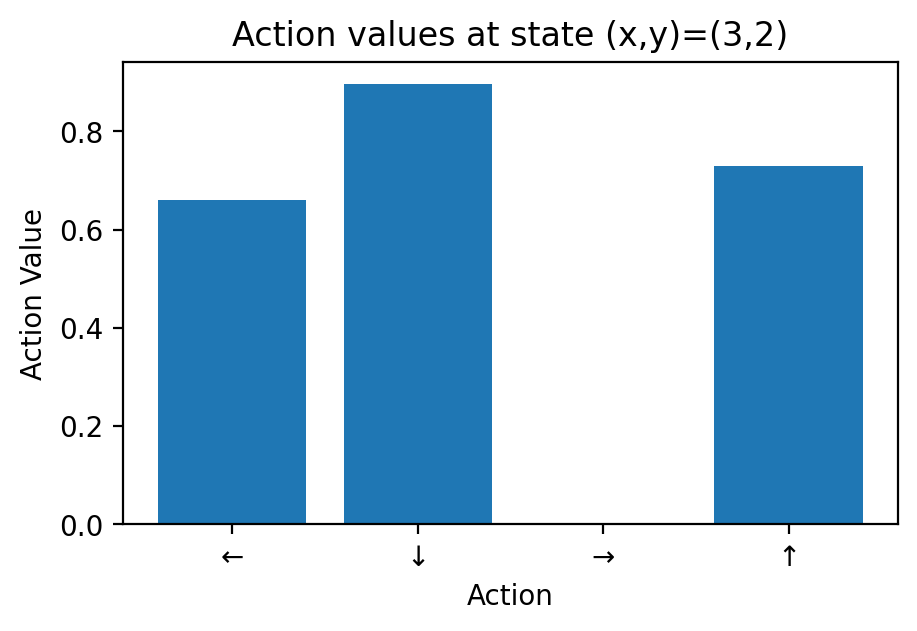

In [6]:
# MC implementation for action value estimation
value_func = np.zeros([num_state, num_action])
action_list = np.arange(0, num_action)

# Initialize an optimal epsilon-greedy policy
epsilon = 0.1
policy = np.zeros([num_state, num_action])
opt_action = [1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0] # optimal action for each state
for state in range(num_state):
    for action in range(num_action):
        if action == opt_action[state]:
            policy[state][action] = 1 - epsilon + 1/num_action * epsilon
        else:
            policy[state][action] = 1/num_action * epsilon

# Estimate action values using MC policy evaluation
value_func = mc_policy_evaluation_action_value(env, policy, value_func)

# Plot action values at state (x,y)=(3,2) cell
plt.figure(figsize=(5, 3), dpi=200)
plt.bar(['←', '↓', '→', '↑'], value_func[10]) # (x,y)=(3,2)
plt.xlabel('Action')
plt.ylabel('Action Value')
plt.title('Action values at state (x,y)=(3,2)')


In the above code, we plot the learned action values for state (3,2) as an example. In this cell, the optimal action is to move downward. Moving right is considered the least favorable action due to the presence of a hole. Moving up and left take the agent away from the goal, making it a suboptimal choice. The learned action values reflect these expectations.

For action value estimation, a 'visit' is defined as a combination of both a state and an action. The average return is computed for each such state-action pair. Similar to state value estimation, as a result of the law of large numbers, the estimate converges to the true value as the number of visits to each state-action pair approaches infinity.

It's important to note that in order to estimate all state-action values accurately, all possible state and action pairs must be explored a sufficient number of times. To determine a good policy, it's crucial to compare all potential actions at each state. Consequently, exploration of all state-action pairs and obtaining reliable value estimates are essential.

One approach to ensure exploration of all pairs is to randomize the initial state-action pair, a technique referred to as 'exploring starts'. These random initial steps guarantee the exploration of all state-action pairs, provided there are a sufficient number of trials. 

Another commonly employed solution, and the one used in the above implementation, is to utilize a policy that introduces stochasticity, with a nonzero probability of selecting all available actions in each state. For example, the $\epsilon$-greedy policy, which combines exploitation (with probability 1-$\epsilon$) and exploration (with probability $\epsilon$), ensures this condition. The previous implementation employed an $\epsilon$-greedy policy and it will converge to the true action values with an infinite number of trials.


## On-policy MC control

We learned how to estimate action values for each state-action pair using the MC method. Now, let's explore how we can identify the optimal policy by utilizing the estimated action values obtained through the MC method. The pseudo-code for this process is presented below.


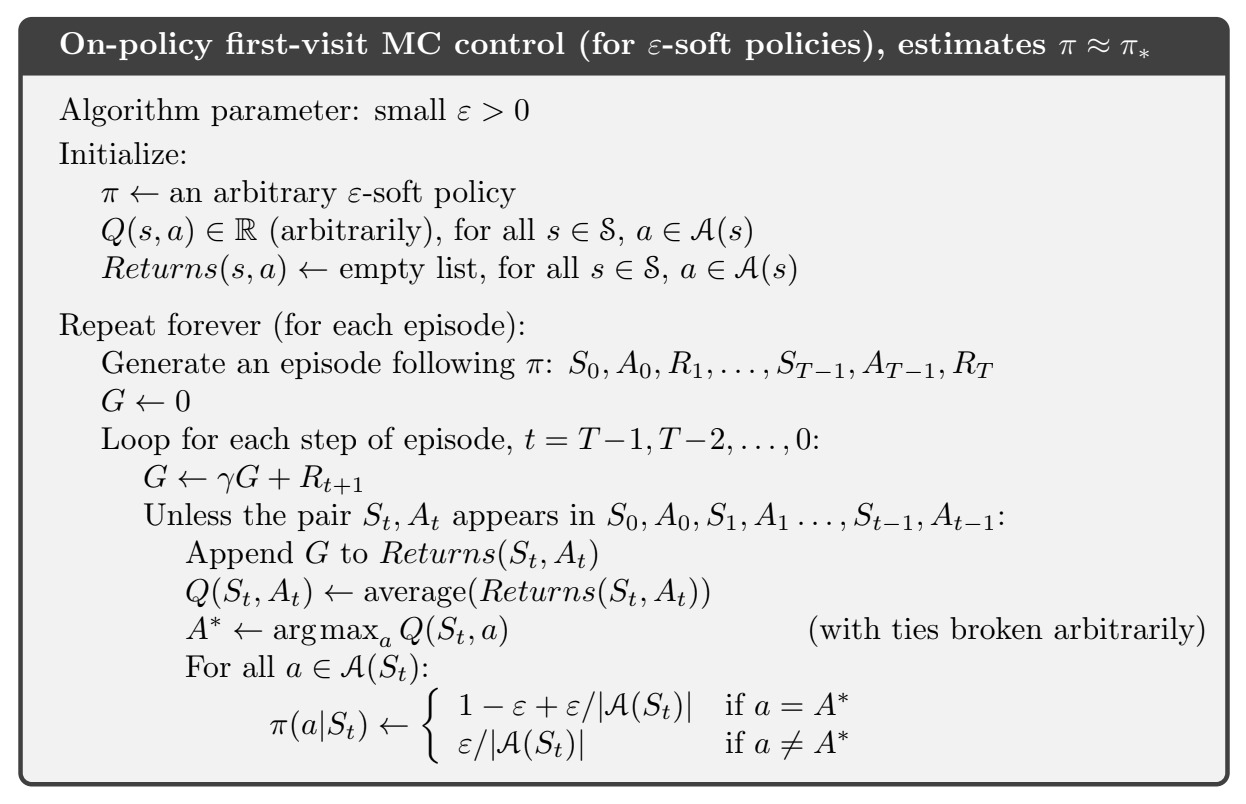

The above algorithm is similar with the Dynamic Programming approach we covered in the previous notebook. However, there are two key distinctions:

- Instead of utilizing state value estimates, we will work with action value estimates.
- To ensure comprehensive exploration of states, we will employ an $\epsilon$-greedy policy, which guarantees visits to all states with non-zero probability.

The following summarizes the main steps outlined in the pseudocode above:

1. Initialize a policy $\pi$, action values $Q(s,a)$, and return values for each state-action pair $Returns(s,a)$.
2. Generate an episode following policy $\pi$ (continue until the episode terminates).
3. Iterate through the time steps from the end of the episode, updating the total return $G$ at each time step.
4. If the time step $t$ represents the first visit to a state-action pair $S_t, A_t$, add $G$ at that time to $Returns(S_t, A_t)$.
5. Calculate the average of all $Returns$ for this state-action pair and update the Q value with the average.
6. Determine the best action to take at state $S_t$ by taking $argmax$ over action.
7. Update the policy at state $S_t$ following an $\epsilon$-greedy policy.

With this understanding, let's implement this algorithm.


In [7]:
def mc_policy_iteration(env, policy, value_func, epsilon=0.05, gamma=0.9, num_episode=1000):
    """
    Run Monte Carlo policy iteration to find an optimal policy.
    """
    # Initialization
    num_state = env.observation_space.n
    num_action = env.action_space.n
    visited_cnt = np.zeros([num_state, num_action])
    return_sum = np.zeros([num_state, num_action])

    for i in range(num_episode):
        G = 0

        # Generate an episode
        states, actions, rewards = generate_episode(env, policy)
        state_action_pairs = np.array([states, actions]).T  # Dimension: [num_timestep, 2]
        T = len(states)

        # Iterate over all time steps with the reverse order
        for t in reversed(range(T)):
            G = gamma * G + rewards[t]  # rewards[t] corresponds to R_{t+1}
            state = states[t]
            action = actions[t]
            state_action_pair = [state, action]

            # Update the action value function when the state action pair is first visit
            if state_action_pair not in [[x[0], x[1]] for x in state_action_pairs[0:t]]:
                return_sum[state][action] += G
                visited_cnt[state][action] += 1
                value_func[state][action] = return_sum[state][action] / visited_cnt[state][action] # compute the average return after the first visit

                # Update policy for the current state
                policy = update_epsilon_soft_policy(state, value_func, policy, num_action, epsilon)

    return value_func, policy


def update_epsilon_soft_policy(state, value_func, policy, num_action, epsilon):
    """
    Update the policy with an epsilon-soft policy.
    """
    # Update policy
    action_values_at_s = value_func[state]
    greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0]
    greedy_action = np.random.choice(greedy_actions)  # Break a tie randomly

    for action in range(num_action):
        if action == greedy_action:
            policy[state][action] = 1 - epsilon + epsilon / num_action
        else:
            policy[state][action] = epsilon / num_action

    return policy


In [8]:
epsilon = 0.05

# Initialize the action value function with random values
value_func = np.random.uniform(low=0, high=0.1, size=(num_state, num_action))

# Initialize an epsilon-soft policy
policy = np.zeros([num_state, num_action])
for state in range(num_state):
    action_values_at_s = value_func[state]

    # Find the action(s) with the highest value, breaking ties randomly
    greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0]
    greedy_action = np.random.choice(greedy_actions)

    for action in range(num_action):
        if action == greedy_action:
            policy[state][action] = 1 - epsilon + epsilon / num_action # Set the probability for the greedy action
        else:
            policy[state][action] = epsilon / num_action # Set the probabilities for non-greedy actions

# Apply Monte Carlo policy iteration to update the policy and action values
value_func, policy = mc_policy_iteration(env, policy, value_func, epsilon, num_episode=1000)


In [9]:
# Display the learned policy
policy = value_function_to_policy(env, value_func, num_state)
display_policy_letters(env, policy)


↓←↓↑
↓→→→
→↓←←
↑→→↓


Because of the randomness by epsilon greedy policy, the learned policy fructuates at each run, but a learned policy represents one of the shortest paths to reach the goal from the start.

## Off-policy MC prediction for estimating action values

In this section, we will learn Off-Policy MC methods, a different approach to reinforcement learning compared to the On-Policy MC methods we've explored so far. Off-Policy methods aim to separate the exploration policy from the target policy, allowing us to efficiently learn an optimal policy and deploy it for optimal behavior. Let's explore how Off-Policy MC works.

### On-Policy vs. Off-Policy

We've studied On-Policy MC methods, where the same policy is used for both collecting samples and updating the value function. However, this approach can be inefficient. The dilemma lies in the fact that we seek to learn action values based on optimal behavior but need to behave sub-optimally for exploration because exploration of all state-action paris are required.

For example, if we use an $\epsilon$-greedy policy for both collecting and updating the value function, the agent continues to explore with a probability of $\epsilon$ even after fully learning the optimal actions. This exploration is necessary for accurately estimating the value function, which is why we employ a soft-policy like the $\epsilon$-greedy policy.

Ideally, we want to distinguish between:

1. The policy for exploring the environment, ensuring that all state-action pairs have a non-zero probability of being visited (Behavior policy, $b$).
2. The policy we consider as the optimal action for each state (Target policy, $\pi$).

By doing this, we can deploy the target policy for optimal behavior once the learning process is complete. Off-Policy MC methods help us achieve this separation.

### The Challenge of Off-Policy Estimation

With Off-Policy MC methods, we have two policies: a behavior policy ($b$) and a target policy ($\pi$). Our goal is to estimate action values under the target policy ($\pi$), but the samples we have are collected using the behavior policy ($b$), which may have a different distribution. To ensure convergence to the true value function under $\pi$, we need to explore all state-action pairs that $\pi$ would visit using $b$. This requirement is known as the assumption of coverage.

The technique used to address this off-distribution problem is called **importance sampling**. Importance sampling is a general method for estimating expected values under one distribution given samples from another. It involves adjusting the weight of each sampled data to match the target policy $\pi$ distribution.

The importance-sampling ratio is defined as:

$ \rho_{t:T(t)-1} = \frac{\pi(A_i | S_i)}{b(A_i | S_i)} $

This ratio calculates the relative probability of the trajectory under the target policy and the behavior policy. It transforms the returns to have the correct expected value under the policy $\pi$.

### Action Value Estimation with Off-Policy MC and Important Sampling

Using the importance-sampling ratio and MC methods, we can estimate the action values under the policy $\pi$ using the data collected with policy $b$ as follows:

$ Q(S_t, A_t) = \frac{\sum_{t \in \tau(s)} \rho_{t:T(t)-1} * G_t}{|\tau(s)|} $

Where $|\tau(s)|$ represents the number of time steps in which state $s$ is visited. This method is called **ordinary importance sampling**.

There's also another version known as **weighted importance sampling**:

$ Q(S_t, A_t) = \frac{\sum_{t \in \tau(s)} \rho_{t:T(t)-1} * G_t}{\sum_{t \in \tau(s)} \rho_{t:T(t)-1}} $

### Ordinary Importance Sampling vs Weighted Importance Sampling

The main difference between ordinary importance sampling and weighted importance sampling lies in their biases and variances. Ordinary importance sampling is unbiased, while weighted importance sampling is biased (though the bias converges asymptotically to zero). On the other hand, the variance of ordinary importance sampling can be unbounded, as the ratios may become very large. In contrast, the weighted estimator ensures that the largest weight on any single return is one, which typically results in lower variance.

In practice, the weighted estimator is often preferred due to its lower variance, and every-visit methods are commonly used as they simplify tracking visited states and are more amenable to approximation techniques.

For more detailed explanation, you can refer to page 105 of Ref[1].


The below section provides pseudocode for implementing Off-Policy Monte Carlo (MC) with every visit and weighted importance sampling.

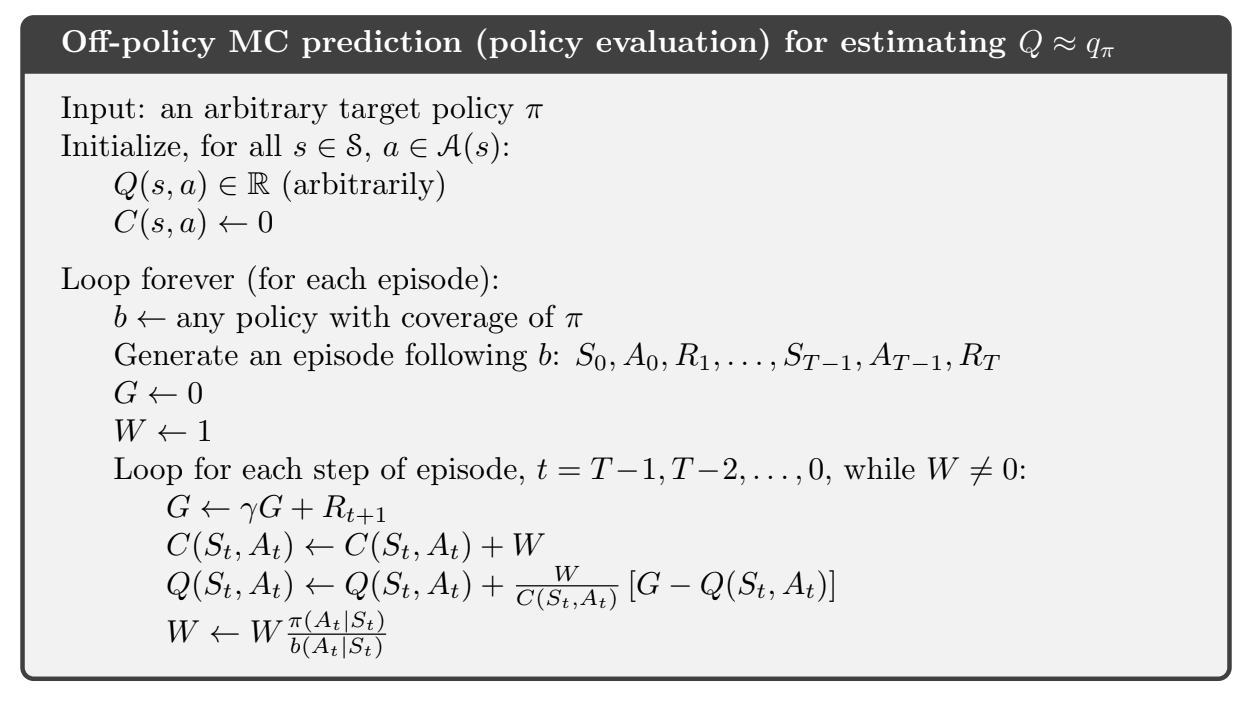

This method involves tracking the total weights for each state-action pair using the variable $C$ to update the value function through weighted averaging. As we discussed, the key to this Offpolicy approach is the simultaneous use of both the behavior policy $b$ and the target policy $\pi$.

We generate episodes using the behavior policy $b$, and then we adjust the sampled data to match the distribution of the target policy $\pi$. This adjusted data is used to update the action value function. Let's implement this algorithm.


In [10]:
def mc_policy_evaluation_off_policy(env, target_policy, value_func, gamma=0.9, num_episode=1000):
    """
    Run Off-policy MC evaluation to estimate action valeus
    """
    # Initialization
    num_state = env.observation_space.n
    num_action = env.action_space.n
    C = np.zeros([num_state, num_action])

    # Initialize the behavior policy (random exploration)
    behavior_policy = np.ones([num_state, num_action]) / num_action
    
    for episode in range(num_episode):

        # Generate an episode using the behavior policy
        states, actions, rewards = generate_episode(env, behavior_policy)
        state_action_pairs = np.array([states, actions]).T  # dim: [num_timestep, 2]
        T = len(states)

        G = 0
        W = 1

        # Iterate over all time steps in reverse order
        for t in reversed(range(T)):
            G = gamma * G + rewards[t]
            state = states[t]
            action = actions[t]
            state_action_pair = [state, action]
            C[state][action] = C[state][action] + W

            # Update the action value function using weighted importance sampling
            value_func[state][action] = value_func[state][action] + W / C[state][action] * (G - value_func[state][action])
            
            # Update the weight for importance sampling
            W = W * target_policy[state][action] / behavior_policy[state][action]

    return value_func


Text(0.5, 1.0, 'Action values at state (x,y)=(3,2)')

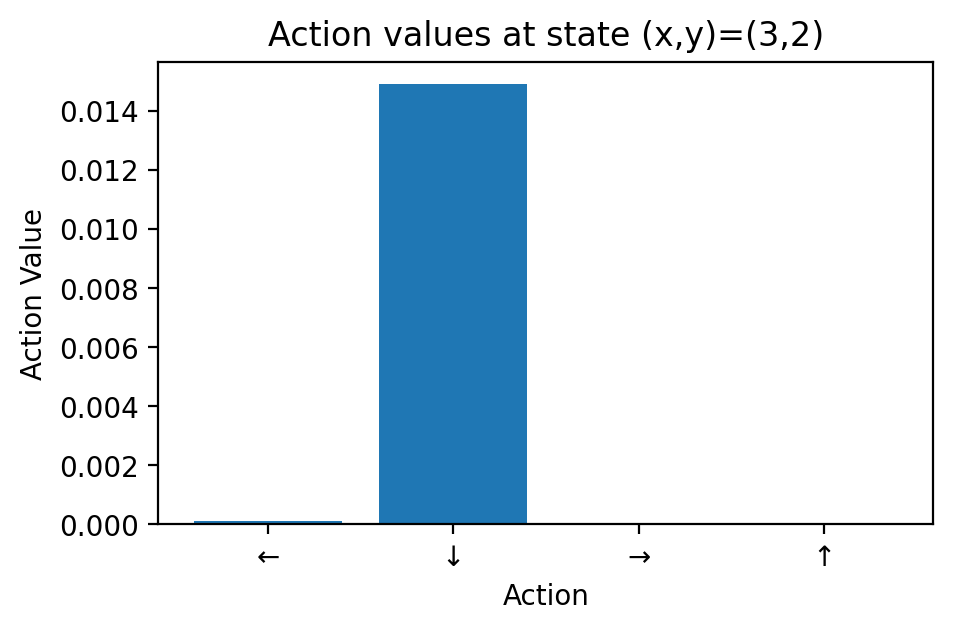

In [11]:
# MC implementation for action value estimation
value_func = np.zeros([num_state, num_action])
action_list = np.arange(0, num_action)
epsilon = 0.05 

# Initialize an epsilon-soft policy.
policy = np.zeros([num_state, num_action])
for state in range(num_state):
    action_values_at_s = value_func[state]
    greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0]  # Find the greedy actions.
    greedy_action = np.random.choice(greedy_actions)  # Break ties by randomly choosing a greedy action.
    for action in range(num_action):
        if action == greedy_action:
            policy[state][action] = 1 - epsilon + epsilon / num_action
        else:
            policy[state][action] = epsilon / num_action

# Perform MC policy evaluation with the epsilon-soft policy.
value_func = mc_policy_evaluation_off_policy(env, policy, value_func)

# Plot action values at state (x,y)=(3,2) cell
plt.figure(figsize=(5, 3), dpi=200)
plt.bar(['←', '↓', '→', '↑'], value_func[10]) # (x,y)=(3,2)
plt.xlabel('Action')
plt.ylabel('Action Value')
plt.title('Action values at state (x,y)=(3,2)')


In the above implementation, we use random exploration as a behavior policy and $\epsilon$ greedy policy as a target policy. 
We plotted the learned action values for state (3,2) as an example. As we discussed, in this cell, the optimal action is to move downward. Moving right is considered the least favorable action due to the presence of a hole. Moving up and left takes the agent away from the goal, making it a suboptimal choice. The learned action values reflect these expectations although the result slightly fluctuates between each run.


## Off-policy MC control for fingind the optimal policy

Lastly, let's thing about the control problem with Off-policy MC methods. 

As discussed earlier, Off-Policy MC methods allow us to use different behavior and target policies. In the pseudocode below, we employ the weighted importance sampling and every-visit method. It's crucial to note again that to accurately estimate the value function, we must visit all state-action pairs with our behavior policy. Therefore, we use a soft policy as the target policy. In the pseudocode, the target policy is the greedy policy, which always selects the action maximizing the return.


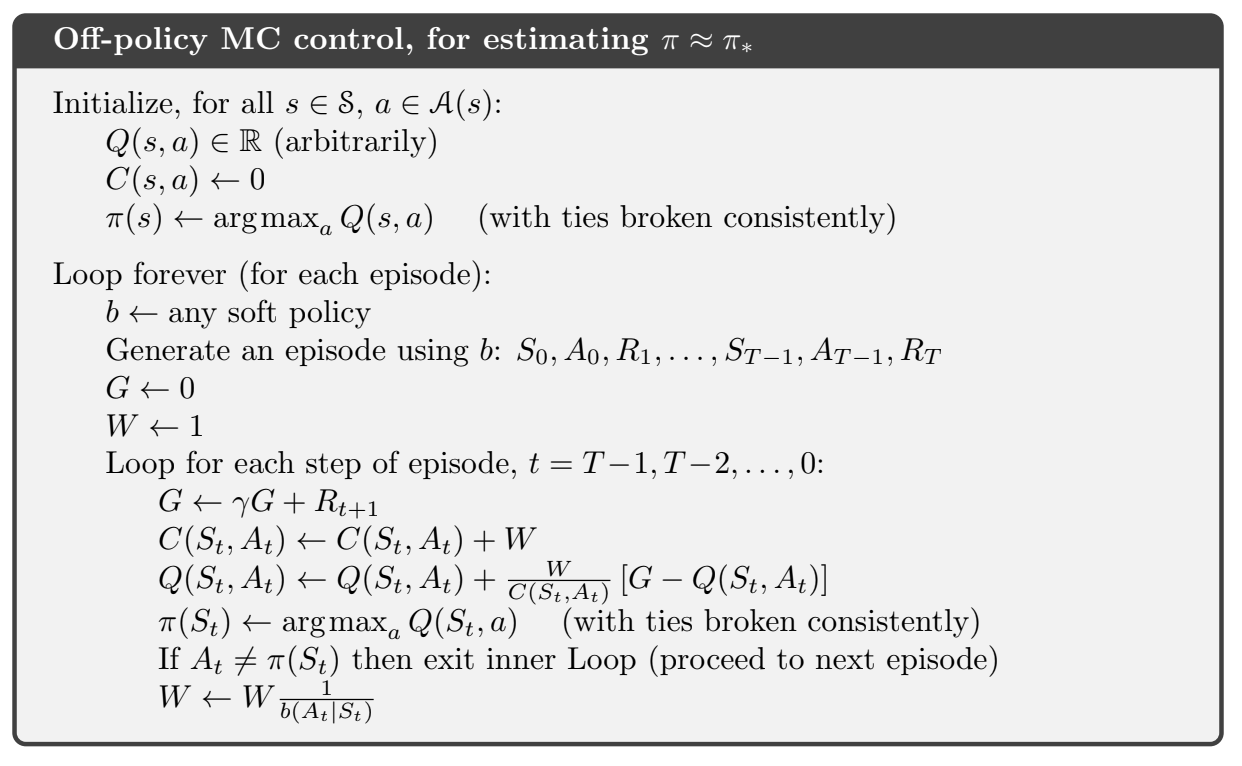

It's important to note that the numerator of the weight update is always 1 because our target policy is a greedy policy. In the updated policy, the probability for the target policy $\pi$ to take the greedy action is 1.

Let's implement this algorithm.


In [12]:
def mc_policy_iteration_off_policy(env, target_policy, value_func, epsilon=0.1, gamma=0.9, num_episode=1000):
    """
    Run Off-policy MC policy iteration
    """
    # Initialization
    num_state = env.observation_space.n
    num_action = env.action_space.n
    C = np.zeros([num_state, num_action]) # cummulative sum of the weights W given to the first n returns (i.e. denominator)
    
    for episode in range(num_episode):
        # Prepare the behavior policy (epsilon-greedy)
        behavior_policy = np.zeros([num_state, num_action])
        for state in range(num_state):
            action_values_at_s = value_func[state]
            greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0]  # Find greedy actions
            greedy_action = np.random.choice(greedy_actions)  # Break ties by randomly choosing a greedy action
            for action in range(num_action):
                if action == greedy_action:
                    behavior_policy[state][action] = 1 - epsilon + epsilon / num_action
                else:
                    behavior_policy[state][action] = epsilon / num_action
        
        # Generate an episode using the behavior policy
        states, actions, rewards = generate_episode(env, behavior_policy)
        state_action_pairs = np.array([states, actions]).T  # dim: [num_timestep, 2]
        T = len(states)
        
        G = 0  # Return
        W = 1  # Importance sampling ratio
                    
        # Iterate over all time steps in reverse order
        for t in reversed(range(T)):            
            G = gamma * G + rewards[t]  # rewards[t] corresponds to R_{t+1}
            state = states[t]
            action = actions[t]
            
            # Update the cumulative sum of weights (denominator)
            C[state][action] = C[state][action] + W
            
            # Update the action value function using weighted importance sampling
            value_func[state][action] = value_func[state][action] + W / C[state][action] * (G - value_func[state][action])
            
            # Update the target policy to be greedy
            action_values_at_s = value_func[state]
            greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0]  # Find greedy actions
            greedy_action = np.random.choice(greedy_actions)  # Break ties by randomly choosing a greedy action
            for a in range(num_action):
                if a == greedy_action:
                    target_policy[state][a] = 1
                else:
                    target_policy[state][a] = 0
            
            # If the current action is not greedy, terminate the episode
            if action != greedy_action:
                break
            
            # Update the importance sampling ratio
            W = W * 1 / behavior_policy[state][action]  # Compute the average return after the first visit
                
    return value_func, target_policy


In [13]:
value_func = np.zeros([num_state, num_action])
# value_func = np.random.uniform(low=0, high=0.1, size=(num_state, num_action)) # random action value

# Initialize the greedy target policy
policy = np.zeros([num_state, num_action])
for state in range(num_state):
    action_values_at_s = value_func[state]
    greedy_actions = np.where(action_values_at_s == np.max(action_values_at_s))[0]  # Find the greedy actions
    greedy_action = np.random.choice(greedy_actions)  # Break ties by randomly choosing a greedy action
    policy[state][greedy_action] = 1

# Perform Off-Policy Monte Carlo policy iteration
value_func, policy = mc_policy_iteration_off_policy(env, policy, value_func, num_episode=1000)

# Convert the value function to a policy
policy = value_function_to_policy(env, value_func, num_state)

# Display the policy using letters (e.g., ←, ↓, →, ↑)
display_policy_letters(env, policy)


→→↓←
↑→↓↓
↑↓↓↓
←→→↓


[Caution] If the value function is initialized with values which are larger than the return the algorithm can receive, it cannot properly update the policy.

An inherent limitation of the current approach is that it larns only from the tails of episodes, specifically when all remaining actions in the episode follow a greedy policy. This limitation can lead to slow learning, especially for states encountered in the early parts of lengthy episodes. 

For instance, in the implementation described above, if random exploration policies are used instead of epsilon-greedy policies, the learning process can be considerably slower. 

To mitigate this issue, one promising solution is to incorporate **temporal difference (TD) learning**. TD-learning, an algorithmic concept that we explore in the next notebook, offers a solution to this challenge by allowing the agent to learn and update its value estimates more dynamically, even when non-greedy actions are prevalent. 


## Summary

In this notebook, we reviewed a range of Monte Carlo methods for solving Markov Decision Processes (MDPs). As the summary, I provide the comparison between the Off-policy methods vs On-policy methods and the comparison between Monte Carlo Methods and Dynamic Programming.

### Off-policy methods vs On-policy methods

When considering Off-policy methods versus On-policy methods:

- **On-policy methods** are generally simpler to grasp and implement. They are well-suited for straightforward policy evaluation.
- **Off-policy methods**, on the other hand, introduce additional concepts and notation, which can make them more complex. They often exhibit higher variance and slower convergence since the data is collected under a different policy.
- However, **Off-policy methods** are more powerful and versatile, offering a broader range of applications. It's worth noting that **On-policy methods** are a specific case where the target and behavior policies are identical.

### Advantages of Monte Carlo over Dynamic Programming

Monte Carlo (MC) methods provide distinct advantages when compared to Dynamic Programming:

- **MC methods** enable the learning of optimal behavior directly through interactions with the environment, without requiring a model of the environment's dynamics.
- These methods can be applied with both real interactions and simulated models, providing flexibility in various scenarios.
- MC methods are particularly efficient when focusing on a specific subset of states, allowing accurate evaluations of regions of interest without the need for precise value estimations across the entire state space.
- Notably, MC methods are often less affected by violations of the Markov property. This is because they do not update value estimates based on the value estimates of successor states, thus minimizing reliance on bootstrapping.

In the next notebook, we will explore another valuable approach to learning value functions and policies, known as TD Learning.

TODO: link to the next notebook

## Ref

- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
